# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Eastenders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data `training.csv` to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

In [1]:
!pip install nltk



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
pip install textblob


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import nltk
nltk.download('brown')  # you only have to run this once

[nltk_data] Downloading package brown to /home/jovyan/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [4]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import brown
from nltk import ngrams

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

%matplotlib inline
pd.options.display.max_colwidth=500


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [5]:
# some useful libraries
from nltk.stem import WordNetLemmatizer  # lemmatization
import nltk # for accessing the stopwords etc.
import re # regex
import string # other string operations
from textblob import TextBlob # for spelling correction

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [8]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

# Merge episode and scene column
epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # need to sort to ensure same initial order
print(episode_scenes[0:5]) # sorted epi-scene col 

shuffle(episode_scenes)    
print(episode_scenes[0:5])
print(len(episode_scenes))

episode_split = int(0.9*len(episode_scenes))    # Split epi-scene into 90-10 train-val data
training_ep_scenes = episode_scenes[:episode_split]   # 90% train
test_ep_scenes = episode_scenes[episode_split:]       # 10% val
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):          # funtion
    if val in training_ep_scenes:       # If input in 90% train data
        return "training"               # label Training
    return "heldout"                    # Held-out/val
display(all_train_data.head())
all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)
len(all_train_data.loc[all_train_data['train_heldout']=='heldout'])
#display(all_train_data.loc[all_train_data['episode_scene']=='1350-4'])

['1350-1', '1350-11', '1350-18', '1350-2', '1350-23']
['1365-25', '1399-12', '1366-22', '1395-26', '1391-29']
1394
1254 140


,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2


1681

In [9]:
epsiode_scene_column_test = test_data.Episode.astype(str) + "-" + test_data.Scene.astype(str)
test_data['episode_scene'] = epsiode_scene_column
test_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene
0,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"You'll be alright Kevin. They're gonna cut you out. It's going to be alright. Come on, just talk to me. Just, just talk to me. Call me names- let me know you're still here with me.",FEMALE,1350-1
1,1350,7,DESERTED CAR PARK EXT NIGHT,OTHER,...I've got pins and needles in my fingers.,MALE,1350-1
2,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,That's the cold.,FEMALE,1350-2
3,1350,7,DESERTED CAR PARK EXT NIGHT,OTHER,Yeah. It's all shutting down.,MALE,1350-2
4,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,It's just the cold.,FEMALE,1350-2
...,...,...,...,...,...,...,...
1762,1398,32,GEORGE STREET EXT NIGHT,JANE,I know. Now Ian come on. Everything's going to be alright. It is. It's going to be alright.,FEMALE,1355-19
1763,1399,27,[NAME] & [NAME]'S BEDROOM INT NIGHT,TANYA,Night night baby. I love you.,FEMALE,1355-20
1764,1399,27,[NAME] & [NAME]'S BEDROOM INT NIGHT,OTHER,Love you too.,FEMALE,1355-20
1765,1399,27,[NAME] & [NAME]'S BEDROOM INT NIGHT,TANYA,"Let's get that under your ankle shall we. Careful, alright? Night night darling. Love you.",FEMALE,1355-20


In [10]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [11]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [12]:
#train_data.drop(index=train_data.index[0], axis=0, inplace=True)
display(train_data)

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [13]:
# Create one document per character
def create_character_document_from_dataframe_t(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
   
    
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():    # if name not already in dic
            character_docs[name] = ""            # add name key and value empty string
            character_line_count[name] = 0      # Add the name key in CLC dict with value 0
        if character_line_count[name]==max_line_count:   # if value of name in CLC is max
            continue                                     # skip
        # Append line to name key value and an end-of-line token after each line
        character_docs[name] += str(line)   + " _EOL_ "  
        character_line_count[name]+=1                    # Add 1 if name is already present
    print("lines per character", character_line_count)
    return character_docs

# Q4. Add dialogue context and scene features (20 marks)

In [14]:
# Create one document per character

def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    df2 = df
    df1 = pd.DataFrame([['1'] * len(df.columns)], columns=df.columns)
    df = df1.append(df, ignore_index=True)
    display(df2.head())
    
    
    character_docs = {}
    character_line_count = {}
    for line, name, gender,i in zip(df2.Line, df2.Character_name, df2.Gender,list(range(1,len(train_data)))):
        if not name in character_docs.keys():    # if name not already in dic
            character_docs[name] = ""            # add name key and value empty string
            character_line_count[name] = 0      # Add the name key in CLC dict with value 0
        if character_line_count[name]==max_line_count:   # if value of name in CLC is max
            continue  # skip
            
            
        # Append line to name key value and an end-of-line token after each line
        
        #print('Name:',name)
        if df.Character_name[i] == name:
            #print(df.Character_name[i])  
            if df.episode_scene[i-1] == df.episode_scene[i] == df.episode_scene[i+1]:
                #print(df.Line[i])
                #print(name, len(str(df.Line[i]).split(" ")))
                
                if name not in avg_dialogue_length.keys():
                    
                    avg_dialogue_length[name] = len(str(df.Line[i]).split(" ")) 
                    num_lines[name] = 1
                else:
                    
                    avg_dialogue_length[name] += len(str(df.Line[i]).split(" ")) 
                    num_lines[name] += 1
                #print(avg_dialogue_length)
                #print(name, df.episode_scene[i], df.Line[i-1],df.Line[i], df.Line[i+1])
                character_docs[name] += str(df.episode_scene[i])+" "+str(df.Line[i-1])+" "+str(df.Line[i])+ " "+str(df.Line[i+1])+" "+ " _EOL_ "  
                character_line_count[name]+=1  
        
                   
                continue
            if df.episode_scene[i-1] != df.episode_scene[i] == df.episode_scene[i+1]:
                
                if name not in avg_dialogue_length.keys():
                    avg_dialogue_length[name] = len(str(df.Line[i]).split(" ")) 
                    num_lines[name] = 1
                else:
                    avg_dialogue_length[name] += len(str(df.Line[i]).split(" ")) 
                    num_lines[name] += 1
                    
                #print(name, df.episode_scene[i],df.Line[i], df.Line[i+1])
                character_docs[name] += str(df.episode_scene[i])+" "+str(df.Line[i])+" "+str(df.Line[i+1]) +" "+ " _EOL_ "  
                character_line_count[name]+=1  
                
                continue
            if df.episode_scene[i-1] == df.episode_scene[i] != df.episode_scene[i+1]:
                
                if name not in avg_dialogue_length.keys():
                    avg_dialogue_length[name] = len(str(df.Line[i]).split(" ")) 
                    num_lines[name] = 1
                else:
                    avg_dialogue_length[name] += len(str(df.Line[i]).split(" ")) 
                    num_lines[name] += 1
                    
                #print(name, df.episode_scene[i],df.Line[i-1], df.Line[i])
                character_docs[name] += str(df.episode_scene[i])+" "+str(df.Line[i-1])+" "+str(df.Line[i])+" "+ " _EOL_ "  
                character_line_count[name]+=1
                 
                continue
            if df.episode_scene[i-1] != df.episode_scene[i] != df.episode_scene[i+1]:
                
                if name not in avg_dialogue_length.keys():
                    avg_dialogue_length[name] = len(str(df.Line[i]).split(" ")) 
                    num_lines[name] = 1
                else:
                    avg_dialogue_length[name] += len(str(df.Line[i]).split(" ")) 
                    num_lines[name] += 1
                    
                #print(name, df.episode_scene[i],df.Line[i]) 
                character_docs[name] += str(df.episode_scene[i])+" "+str(df.Line[i])+ " _EOL_ "  
                character_line_count[name]+=1
                
                continue
        #character_docs[name] +=  str(line)   + " _EOL_ "  
        #character_line_count[name]+=1 
    #del character_line_count['1']
    #print("lines per character", character_line_count)
    #print(avg_dialogue_length,"\n",num_lines)
    #del character_docs["1"]
    print(i)
    return character_docs
            

In [15]:
#train_character_docs

In [16]:
#c = [to_feature_vector_dictionary(doc, [gender_model(name)[0], POS_tag(doc)]) for name, doc in training_corpus]
#c

In [17]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
avg_dialogue_length = {}
num_lines = {}
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)

print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training


13637
Num. Characters:  16 

SHIRLEY Number of Words:  10314
OTHER Number of Words:  8586
JACK Number of Words:  10500
RONNIE Number of Words:  10666
TANYA Number of Words:  10022
SEAN Number of Words:  9990
ROXY Number of Words:  10511
HEATHER Number of Words:  11161
MAX Number of Words:  10594
IAN Number of Words:  11014
JANE Number of Words:  10445
STACEY Number of Words:  10568
PHIL Number of Words:  11329
MINTY Number of Words:  11404
CHRISTIAN Number of Words:  10160
CLARE Number of Words:  10575
total words 167839


In [18]:
#train_character_docs

# Q1. Improve pre-processing (20 marks)

In [19]:

preprocessing_switches = {
  'remove_punctuation': True,
  'convert_to_lowercase': True,
  'remove_stopwords': True,
  'apply_stemming':  True,
  'apply_lemmatization': True}

In [20]:
from nltk.stem import PorterStemmer
# different pre-processing techniques which get called altogether by pre_process


def remove_punctuation(text):
    
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings
    text = re.sub(r'[^\w\s]', '', text) # remove anything that isn't word or space
    tokens = re.split(r"\s+",text)
  
    return tokens

# Convert everything to lowercase
def convert_to_lowercase(tokens):
    return [token.lower() for token in tokens if token.isalpha()]

# Remove stopwaords using nltk stopwords corpus
def remove_stopwords(tokens):
    stopword_list = nltk.corpus.stopwords.words('english')
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    #print(tokens)
    return filtered_tokens

# Stemming
def apply_stemming(tokens, ps = PorterStemmer()):
    return [ps.stem(token) for token in tokens] 

# Lemmatization
def apply_lemmatization(tokens, wnl=WordNetLemmatizer()):   
    return [wnl.lemmatize(token) for token in tokens]


def pre_process(text):
    """ Technique which will apply the techniques if they are set to 
    True in the global dict ::preprocessing_switches::
    """
    #tokens = tokenize_text(text)
    if preprocessing_switches["remove_punctuation"]:
        tokens = remove_punctuation(text)
    if preprocessing_switches["remove_punctuation"]==False:
        tokens = text.split()
    if preprocessing_switches["convert_to_lowercase"]:
        tokens = convert_to_lowercase(tokens)
    if preprocessing_switches["remove_stopwords"]:
        tokens = remove_stopwords(tokens)
    if preprocessing_switches["apply_lemmatization"]:
        tokens = apply_lemmatization(tokens)
    if preprocessing_switches["apply_stemming"]:
        tokens = apply_stemming(tokens)
    return tokens

In [21]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

# Q2. Improve linguistic feature extraction (20 marks)

In [22]:
# Feature exaction switches
extra_feature_switches = {'n_gram': True,
  'POS tagging on ngram': False,
  'Avg Dialogue length':True,
  'gender': True,
  'minimum doc freq': False}

In [23]:

def POS_tag(character_doc):
    l1 = []
    l2=  []
    counts1={}
    n = 3
    character_doc_ngram = ngrams(character_doc, n) # Extract ngram
        
    for ngram in character_doc_ngram:     # For each ngram sequence in character doc
        l2.append(nltk.pos_tag(ngram))     # Assign its POS tag
        
    for tag in l2:                         # For each ngram-tag sequence
        ngram_tag = list(zip(*tag))[1]    # extract just tuples of tag sequences
           
        if str(ngram_tag) in counts1.keys(): # If tag seq already in dictionary, add 1 
            counts1[str(ngram_tag)] += 1     
        else:
            counts1[str(ngram_tag)] = 1      # If not assign 1
    return counts1

def avg_dialogue_len(name,max_len_line):
    avg = avg_dialogue_length[name]/max_len_line
    #print(name,int(avg))
    return int(avg)

In [24]:
def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens...
    
    Initially just a simple count. Improve this for Q2...
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    #print(character_doc)
    
    l1 = []
    l2=  []
    
    counts={}
    
    if extra_feature_switches['Avg Dialogue length']:
        #print(character_doc)
        #print(len(character_doc))
        counts['Avg Dialogue length'] = avg_dialogue_len(extra_features[2][0],(extra_features[2][1]))
       
    if extra_feature_switches['gender']:
        if extra_features[0] == 1:            
            gender = 'Female'
        else:
            gender = 'Male'
        counts['Gender']=gender # {gender:Female or Male}
    #counts_new = {}   
    
        
    if extra_feature_switches['n_gram']:
       
        n = 1
        character_doc_ngram = ngrams(character_doc, n)
        
        for ngram in character_doc_ngram: 
            #print(ngram[])# For each ngram sequence in character doc
            if str(ngram) in counts.keys():   # If ngram seq already in dictionary, add 1 
                counts[str(ngram)] += 1     
            else:
                counts[str(ngram)] = 1  
    
        
    if extra_feature_switches['POS tagging on ngram']:
        counts.update(extra_features[1])
       
    counts_new = {}
    if extra_feature_switches['minimum doc freq']:
        
        for k,v in counts.items():
            try: 
                #print(v)
                if v>3:
                    #print(v)
                    counts_new[k]=v
                else:
                    continue
            except:
                
                #print('Error string')
                counts_new[k] = v 
            continue

    return counts


In [25]:
#c = [to_feature_vector_dictionary(doc, [gender_model(name)[0], POS_tag(doc),[name,num_lines[name]]]) 
     #for name, doc in training_corpus]

# avg dialogue len for each character

In [26]:

#c = [to_feature_vector_dictionary(doc, [gender_model(name)[0], POS_tag(doc),[name,num_lines[name]]]) 
    # for name, doc in val_corpus]

# Feature set of each character

In [27]:
## Gender Predictor Model

In [28]:
train_data['Character_name'].unique()

array(['SHIRLEY', 'OTHER', 'JACK', 'RONNIE', 'TANYA', 'SEAN', 'ROXY',
       'HEATHER', 'MAX', 'IAN', 'JANE', 'STACEY', 'PHIL', 'MINTY',
       'CHRISTIAN', 'CLARE'], dtype=object)

In [29]:
train_og = train_data[:]
train_data1 = train_data[:]
train_data1.drop(index=train_data.index[0], axis=0, inplace=True)

In [30]:

train_data1['Character_name'] = train_data1['Character_name'].replace(['SHIRLEY', 'OTHER', 'JACK', 'RONNIE', 'TANYA', 'SEAN', 'ROXY','HEATHER', 'MAX', 'IAN', 'JANE', 'STACEY', 'PHIL', 'MINTY','CHRISTIAN', 'CLARE'],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],inplace=False)
train_data1['Gender'] = train_data1['Gender'].replace(['FEMALE','MALE'],[1,2],inplace=False)

X = np.array(train_data1['Character_name']).reshape(-1, 1)
y = np.array(train_data1['Gender']).reshape(-1, 1)

In [31]:
train_data['Character_name'].unique()

array(['SHIRLEY', 'OTHER', 'JACK', 'RONNIE', 'TANYA', 'SEAN', 'ROXY',
       'HEATHER', 'MAX', 'IAN', 'JANE', 'STACEY', 'PHIL', 'MINTY',
       'CHRISTIAN', 'CLARE'], dtype=object)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
parameters = {'n_neighbors': [i for i in range(2,20,1)]}

knn = KNeighborsClassifier()
model = make_pipeline(GridSearchCV(knn, parameters,cv=5))

model.fit(X_train, y_train)
print("Model Test Score:",model.score(X_test,y_test))

Model Test Score: 0.820869990224829


In [33]:


def gender_model(name):
    #print(name)
    if name == 'SHIRLEY':
        X_g = 1
    if name == 'OTHER':
        X_g = 2
    if name == 'JACK':
        X_g = 3
    if name == 'RONNIE':
        X_g = 4
    if name == 'TANYA':
        X_g = 5
    if name == 'SEAN':
        X_g = 6
    if name == 'ROXY':
        X_g = 7
    if name == 'HEATHER':
        X_g = 8
    if name == 'MAX':
        X_g = 9
    if name == 'IAN':
        X_g = 10
    if name == 'JANE':
        X_g = 11
    if name == 'STACEY':
        X_g = 12
    if name == 'PHIL':
        X_g = 13
    if name == 'MINTY':
        X_g = 14
    if name == 'CHRISTIAN':
        X_g = 15
    if name == 'CLARE':
        X_g = 16
        
    pred = model.predict(np.array(X_g).reshape(-1,1))

    
    return pred

# Q5. Improve the vectorization method (20 marks)

In [34]:
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction import FeatureHasher
from sklearn.naive_bayes import MultinomialNB


#corpusVectorizer = DictVectorizer()# corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


pipe = Pipeline([('corpusVectorizer', DictVectorizer()),('tfid', TfidfTransformer())])
#pipe = Pipeline([('corpusVectorizer', DictVectorizer()),('onehot', Binarizer())])
#pipe = Pipeline([('corpusVectorizer', DictVectorizer())])


def create_document_matrix_from_corpus(corpus, fitting):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        pipe.fit([to_feature_vector_dictionary(doc, [gender_model(name)[0], POS_tag(doc),[name,num_lines[name]]]) 
                  for name, doc in corpus])
    doc_feature_matrix = pipe.transform([to_feature_vector_dictionary(doc, [gender_model(name)[0],
                                                    POS_tag(doc),[name,num_lines[name]]]) for name, doc in corpus])
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [35]:
training_feature_matrix

<16x3857 sparse matrix of type '<class 'numpy.float64'>'
	with 15591 stored elements in Compressed Sparse Row format>

In [36]:
val_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
56,1350,18,BRANNINGS' HOUSE INT NIGHT,TANYA,Who's that?,FEMALE,1350-18,heldout
57,1350,18,BRANNINGS' HOUSE INT NIGHT,MAX,Tanya! Tanya it's me. I wanna give Oscar a New Year kiss. Tan?,MALE,1350-18,heldout
58,1350,18,BRANNINGS' HOUSE INT NIGHT,SEAN,Right. I'll have a word.,MALE,1350-18,heldout
59,1350,18,BRANNINGS' HOUSE INT NIGHT,TANYA,"No no no leave it, leave it. He ain't got a key. He'll go away. Do you want some crisps?",FEMALE,1350-18,heldout
60,1350,18,BRANNINGS' HOUSE INT NIGHT,MAX,"Who, who you got in there, Tan? Tan, I've got a right to know who my kids are being exposed to. I bet you ain't got anyone have ya? You're just sitting there with a bottle of wine all on your Jack, Tan?",MALE,1350-18,heldout
...,...,...,...,...,...,...,...,...
15268,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,STACEY,"I asked him to leave you. I asked him again and again. I begged him. And if he had. I'd have been with him. I'd have been with him now. So it might suit you to think that it was all Max but it wasn't, not really, not in the end.",FEMALE,1399-29,heldout
15269,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,TANYA,Why you telling me all this eh?,FEMALE,1399-29,heldout
15270,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,STACEY,"Because I don't want you using Sean to punish him, I don't want you wrecking your family cause of me. I just, I just want it all over.",FEMALE,1399-29,heldout
15271,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,TANYA,It is over. It's all over. Will you please just go home now and leave me alone.,FEMALE,1399-29,heldout


In [37]:
# get the validation data- only 40 lines used for each character
avg_dialogue_length = {}
num_lines = {}
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
56,1350,18,BRANNINGS' HOUSE INT NIGHT,TANYA,Who's that?,FEMALE,1350-18,heldout
57,1350,18,BRANNINGS' HOUSE INT NIGHT,MAX,Tanya! Tanya it's me. I wanna give Oscar a New Year kiss. Tan?,MALE,1350-18,heldout
58,1350,18,BRANNINGS' HOUSE INT NIGHT,SEAN,Right. I'll have a word.,MALE,1350-18,heldout
59,1350,18,BRANNINGS' HOUSE INT NIGHT,TANYA,"No no no leave it, leave it. He ain't got a key. He'll go away. Do you want some crisps?",FEMALE,1350-18,heldout
60,1350,18,BRANNINGS' HOUSE INT NIGHT,MAX,"Who, who you got in there, Tan? Tan, I've got a right to know who my kids are being exposed to. I bet you ain't got anyone have ya? You're just sitting there with a bottle of wine all on your Jack, Tan?",MALE,1350-18,heldout


1681
Num. Characters:  16 

TANYA Num of Words:  1188
MAX Num of Words:  1526
SEAN Num of Words:  934
SHIRLEY Num of Words:  1187
OTHER Num of Words:  786
STACEY Num of Words:  1298
RONNIE Num of Words:  1049
JACK Num of Words:  992
PHIL Num of Words:  1193
IAN Num of Words:  1223
JANE Num of Words:  1222
ROXY Num of Words:  1095
HEATHER Num of Words:  1083
MINTY Num of Words:  1366
CHRISTIAN Num of Words:  1083
CLARE Num of Words:  1305
total words 18530


In [38]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [39]:
val_feature_matrix

<16x3857 sparse matrix of type '<class 'numpy.float64'>'
	with 3308 stored elements in Compressed Sparse Row format>

In [40]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [41]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [42]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [43]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.3125
mean cosine similarity 0.5565480518156722
12 correct out of 16 / accuracy: 0.75


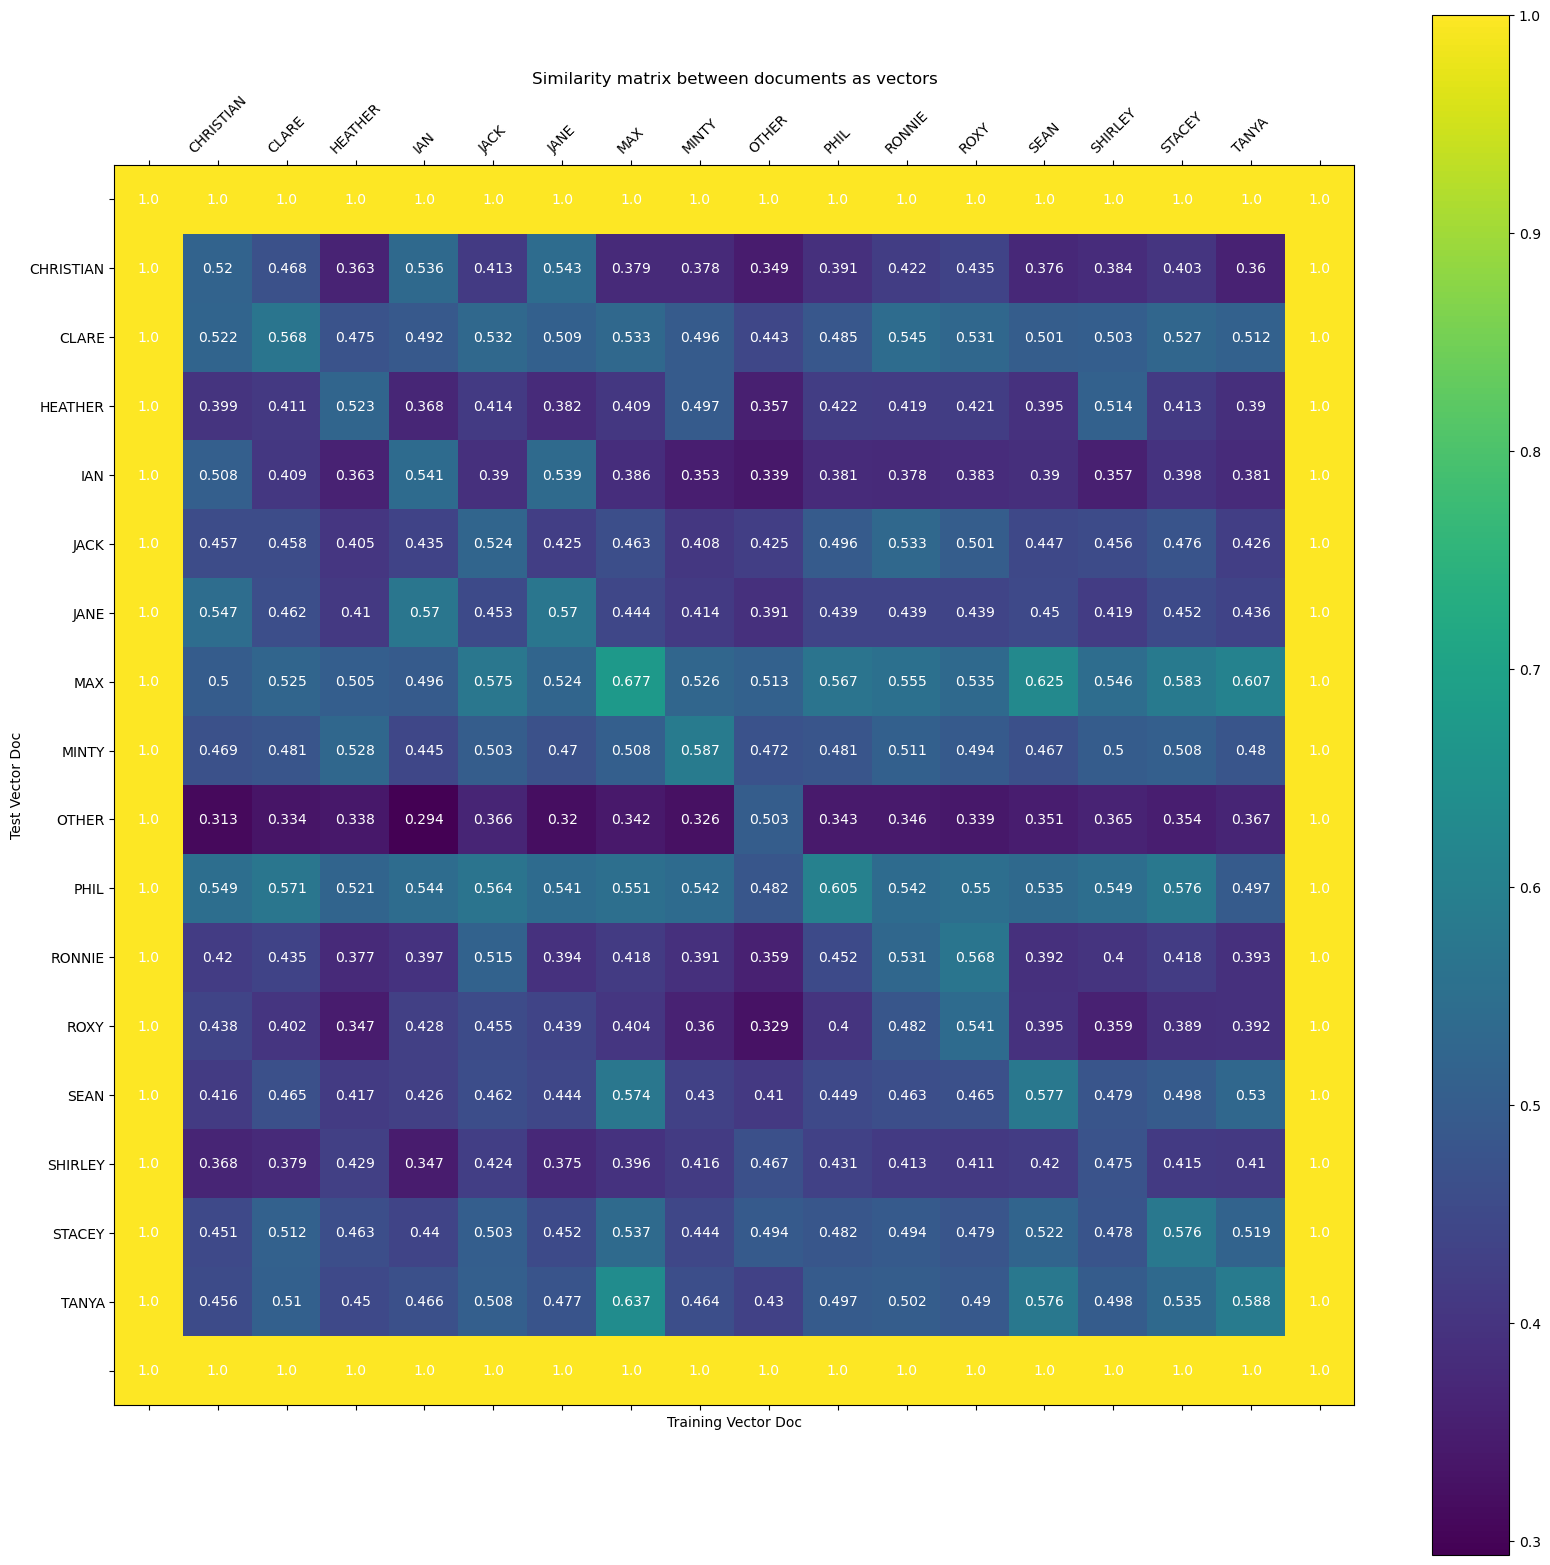

In [44]:
plot_heat_map_similarity(df)

# Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

In [45]:
avg_dialogue_length = {}
num_lines = {}
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
avg_dialogue_length = {}
num_lines = {}
# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]

print()
# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training


13637
Num. Characters:  16 

SHIRLEY Number of Words:  11483
OTHER Number of Words:  9358
JACK Number of Words:  11492
RONNIE Number of Words:  11833
TANYA Number of Words:  10988
SEAN Number of Words:  9779
ROXY Number of Words:  11530
HEATHER Number of Words:  11368
MAX Number of Words:  12065
IAN Number of Words:  12330
JANE Number of Words:  11677
STACEY Number of Words:  11768
PHIL Number of Words:  12514
MINTY Number of Words:  12303
CHRISTIAN Number of Words:  11010
CLARE Number of Words:  12121
total words 183619


,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene
0,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"You'll be alright Kevin. They're gonna cut you out. It's going to be alright. Come on, just talk to me. Just, just talk to me. Call me names- let me know you're still here with me.",FEMALE,1350-1
1,1350,7,DESERTED CAR PARK EXT NIGHT,OTHER,...I've got pins and needles in my fingers.,MALE,1350-1
2,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,That's the cold.,FEMALE,1350-2
3,1350,7,DESERTED CAR PARK EXT NIGHT,OTHER,Yeah. It's all shutting down.,MALE,1350-2
4,1350,7,DESERTED CAR PARK EXT NIGHT,SHIRLEY,It's just the cold.,FEMALE,1350-2


1767
Num. Characters:  16 

SHIRLEY Number of Words:  1169
OTHER Number of Words:  1097
HEATHER Number of Words:  1049
PHIL Number of Words:  1274
SEAN Number of Words:  1235
TANYA Number of Words:  1217
MAX Number of Words:  1160
JACK Number of Words:  1067
IAN Number of Words:  1285
JANE Number of Words:  1159
STACEY Number of Words:  1335
ROXY Number of Words:  1104
RONNIE Number of Words:  1060
CHRISTIAN Number of Words:  1324
MINTY Number of Words:  1434
CLARE Number of Words:  1092
total words 19061

mean rank 1.25
mean cosine similarity 0.6177678716260413
14 correct out of 16 / accuracy: 0.875
